In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, classification_report, roc_auc_score, plot_roc_curve

from xgboost import XGBClassifier

# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline as ImPipeline

pd.options.display.max_columns = None
seed = 50

**Reading in the dataset**. This is from an online competition on DrivenData, so the provided test set doesn't have labels. For this reason I'll treat the provided training set and labels as a the whole dataset, on which I will later peform a train-test split.

In [2]:
features = pd.read_csv('data/training_set_features.csv')
target = pd.read_csv('data/training_set_labels.csv')

In [3]:
data = pd.concat([features, target], axis=1)

In [4]:
data = data.drop(columns=['respondent_id', 'seasonal_vaccine'])

In [5]:
data.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [7]:
(data.isna().sum() / len(data)) * 100

h1n1_concern                    0.344479
h1n1_knowledge                  0.434343
behavioral_antiviral_meds       0.265848
behavioral_avoidance            0.778822
behavioral_face_mask            0.071142
behavioral_wash_hands           0.157262
behavioral_large_gatherings     0.325757
behavioral_outside_home         0.307036
behavioral_touch_face           0.479275
doctor_recc_h1n1                8.087767
doctor_recc_seasonal            8.087767
chronic_med_condition           3.635751
child_under_6_months            3.070356
health_worker                   3.010447
health_insurance               45.957989
opinion_h1n1_vacc_effective     1.464036
opinion_h1n1_risk               1.452803
opinion_h1n1_sick_from_vacc     1.479013
opinion_seas_vacc_effective     1.729884
opinion_seas_risk               1.924589
opinion_seas_sick_from_vacc     2.010709
age_group                       0.000000
education                       5.268282
race                            0.000000
sex             

#### Observations:
There are several features with a large amount of data missing. I'll have to decide if I should impute them with some value or drop them. 

In particular, `health_insurance` has 46% of its data missing, but I would rather not drop that whole feature because it seems pertinent to the matter of taking an H1N1 vaccine. 

`employment_industry` and `employment_occupation` have half their data missing. The values are encoded in an odd way and are not interpretable, so I'll drop these columns.

In [8]:
X = data.drop(columns=['h1n1_vaccine', 'employment_industry', 'employment_occupation'])
y = data['h1n1_vaccine']

#### Train-test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

In [10]:
X_train_num = X_train.select_dtypes('number')
X_train_obj = X_train.select_dtypes('object')

#### Imputing all missing values with the mode or most frequent value of that column

In [11]:
num_imputer = SimpleImputer(strategy='most_frequent')
obj_imputer = SimpleImputer(strategy='most_frequent')

In [12]:
X_train_imp = pd.concat(
    [
        # Imputing numerical columns with mode
        pd.DataFrame(num_imputer.fit_transform(X_train_num), columns=X_train_num.columns, index=X_train_num.index),
        # Imputing object columns with mode
        pd.DataFrame(obj_imputer.fit_transform(X_train_obj), columns=X_train_obj.columns, index=X_train_obj.index)
    ],
    axis=1
)

# If I don't impute the two types of columns separately, the numerical
# columns end up being objects in the resulting dataframe. That causes
# problems in the one-hot encoding step

No more missing values

In [13]:
X_train_imp.isna().sum()

h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
health_insurance               0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
household_adults               0
household_children             0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment

#### One-hot encoding and scaling

In [14]:
X_train_ohe = pd.get_dummies(X_train_imp)

In [15]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_ohe), columns=X_train_ohe.columns, index=X_train_ohe.index)

In [16]:
X_train_scaled.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_< 12 Years,education_College Graduate,education_Some College,race_Black,race_Hispanic,race_Other or Multiple,race_White,sex_Female,sex_Male,"income_poverty_<= $75,000, Above Poverty","income_poverty_> $75,000",income_poverty_Below Poverty,marital_status_Married,marital_status_Not Married,rent_or_own_Own,rent_or_own_Rent,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA
16087,-0.676565,-0.421361,-0.226203,0.607463,-0.27149,0.456719,-0.745715,-0.715092,0.683194,-0.501560,-0.656755,1.627406,-0.29304,-0.349649,0.262911,1.142294,-0.264320,1.221804,0.901908,-0.513660,-0.823109,1.475415,-0.570986,2.011619,-0.409959,-0.491873,-0.513151,-0.584614,-0.527251,-0.311148,-0.871042,1.674841,-0.293341,-0.265721,-0.253896,0.508956,0.824503,-0.824503,-1.346992,-0.582923,2.972051,-1.123387,1.123387,-1.877367,1.877367,-1.127832,1.264624,-0.242215,-0.285234,-0.347578,-0.207916,-0.375221,-0.347036,-0.287784,-0.440498,-0.301889,2.911173,-0.363260,-0.883607,1.549040,-0.604152
9261,0.420552,1.198574,-0.226203,0.607463,-0.27149,0.456719,1.340995,1.398422,0.683194,-0.501560,1.522637,-0.614475,-0.29304,-0.349649,0.262911,1.142294,-0.264320,1.221804,0.901908,0.943031,-0.823109,0.146194,-0.570986,-0.497112,-0.409959,-0.491873,-0.513151,1.710530,-0.527251,-0.311148,1.148050,-0.597072,-0.293341,-0.265721,-0.253896,0.508956,-1.212852,1.212852,-1.346992,1.715492,-0.336468,0.890165,-0.890165,0.532661,-0.532661,0.886657,-0.790749,-0.242215,-0.285234,2.877055,-0.207916,-0.375221,-0.347036,-0.287784,-0.440498,-0.301889,-0.343504,-0.363260,-0.883607,-0.645561,1.655213
16193,0.420552,1.198574,-0.226203,0.607463,-0.27149,0.456719,-0.745715,-0.715092,0.683194,1.993781,1.522637,1.627406,-0.29304,-0.349649,0.262911,1.142294,-0.264320,-0.259507,0.901908,0.943031,-0.070559,-1.183026,1.599195,-0.497112,-0.409959,2.033043,-0.513151,-0.584614,-0.527251,-0.311148,1.148050,-0.597072,-0.293341,-0.265721,-0.253896,0.508956,0.824503,-0.824503,0.742395,-0.582923,-0.336468,-1.123387,1.123387,-1.877367,1.877367,0.886657,-0.790749,-0.242215,-0.285234,2.877055,-0.207916,-0.375221,-0.347036,-0.287784,-0.440498,-0.301889,-0.343504,-0.363260,1.131725,-0.645561,-0.604152
18216,-0.676565,-0.421361,-0.226203,-1.646191,-0.27149,0.456719,-0.745715,-0.715092,-1.463712,-0.501560,1.522637,-0.614475,-0.29304,2.860009,0.262911,0.146076,1.302513,1.221804,0.901908,-0.513660,-0.823109,-1.183026,-0.570986,-0.497112,-0.409959,2.033043,-0.513151,-0.584614,-0.527251,-0.311148,-0.871042,1.674841,-0.293341,-0.265721,-0.253896,0.508956,0.824503,-0.824503,0.742395,-0.582923,-0.336468,-1.123387,1.123387,-1.877367,1.877367,0.886657,-0.790749,-0.242215,-0.285234,-0.347578,4.809629,-0.375221,-0.347036,-0.287784,-0.440498,-0.301889,-0.343504,-0.363260,-0.883607,1.549040,-0.604152
9161,0.420552,-0.421361,-0.226203,0.607463,-0.27149,0.456719,-0.745715,-0.715092,0.683194,-0.501560,-0.656755,-0.614475,-0.29304,-0.349649,0.262911,1.142294,1.302513,-1.000162,0.901908,1.671376,-0.823109,0.146194,-0.570986,-0.497112,-0.409959,-0.49187

#### Applying preprocessing steps to test set

In [17]:
X_test_num = X_test.select_dtypes('number')
X_test_obj = X_test.select_dtypes('object')

X_test_imp = pd.concat(
    [
        # Imputing numerical columns with mode
        pd.DataFrame(num_imputer.transform(X_test_num), columns=X_test_num.columns, index=X_test_num.index),
        # Imputing object columns with mode
        pd.DataFrame(obj_imputer.transform(X_test_obj), columns=X_test_obj.columns, index=X_test_obj.index)
    ],
    axis=1
)

X_test_ohe = pd.get_dummies(X_test_imp)

X_test_scaled = pd.DataFrame(scaler.transform(X_test_ohe), columns=X_test_ohe.columns, index=X_test_ohe.index)

#### A function to show various metrics for a given fitted model

In [18]:
def model_results(estimator, X, y_true, cv=False, k=5):
    """
    Returns a dictionary of various metrics for a fitted model
    """
    results = {}
    if cv:
        results['cv_accuracy'] = np.mean(cross_val_score(estimator, X, y_true, cv=k))
    else:
        pass
    results['accuracy'] = accuracy_score(y_true, estimator.predict(X))
    results['precision'] = precision_score(y_true, estimator.predict(X))
    results['recall'] = recall_score(y_true, estimator.predict(X))
    results['f1'] = f1_score(y_true, estimator.predict(X))
    results['roc_auc'] = roc_auc_score(y_true, estimator.predict_proba(X)[:,1])
    return results

## Modeling

### Vanilla Logistic Regression Model

In [19]:
logreg = LogisticRegression()

In [20]:
logreg.fit(X_train_scaled, y_train)

LogisticRegression()

In [21]:
model_results(logreg, X_train_scaled, y_train, cv=True)

{'cv_accuracy': 0.8376934598102845,
 'accuracy': 0.8394408387418871,
 'precision': 0.6914135733033371,
 'recall': 0.43521359452442765,
 'f1': 0.5341830822711472,
 'roc_auc': 0.8366132311167994}

#### Grid Search on Logistic Regression

In [22]:
grid = {
    'solver':['lbfgs', 'liblinear'],
    'C': [1, 1e2, 1e5, 1e10],
    'fit_intercept': [True, False]
}

gs = GridSearchCV(
    estimator=logreg,
    param_grid=grid,
    cv=5
)

In [23]:
gs.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1, 100.0, 100000.0, 10000000000.0],
                         'fit_intercept': [True, False],
                         'solver': ['lbfgs', 'liblinear']})

In [24]:
gs.best_params_

{'C': 1, 'fit_intercept': True, 'solver': 'lbfgs'}

In [25]:
model_results(gs.best_estimator_, X_train_scaled, y_train, cv=True)

{'cv_accuracy': 0.8376934598102845,
 'accuracy': 0.8394408387418871,
 'precision': 0.6914135733033371,
 'recall': 0.43521359452442765,
 'f1': 0.5341830822711472,
 'roc_auc': 0.8366132311167994}

**The grid search returned the same parameters as and results as the vanilla logistic regression model.**

### Random Forest Classifier

In [26]:
rfc = RandomForestClassifier()

In [27]:
rfc.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [28]:
model_results(rfc, X_train_scaled, y_train, cv=True,)

{'cv_accuracy': 0.8346979530703944,
 'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'f1': 1.0,
 'roc_auc': 1.0}

In [29]:
# Why is this so overfit???

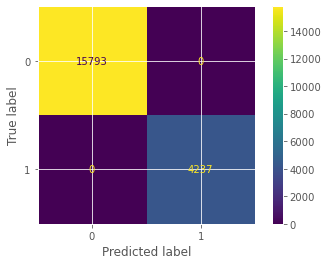

In [30]:
plot_confusion_matrix(rfc, X_train_scaled, y_train);

In [31]:
def plot_feature_importances(model, features=X_train_scaled.columns.tolist(), return_df=False):
    df = pd.DataFrame(
        zip(X_train_scaled.columns.tolist(), model.feature_importances_.tolist()),
        columns=['feature', 'importance']
    ).sort_values(by='importance', ascending=True)
    fig, ax = plt.subplots(figsize=(5, 13))
    ax.barh(y=df['feature'], width=df['importance'])
    plt.show();
    if return_df:
        return df

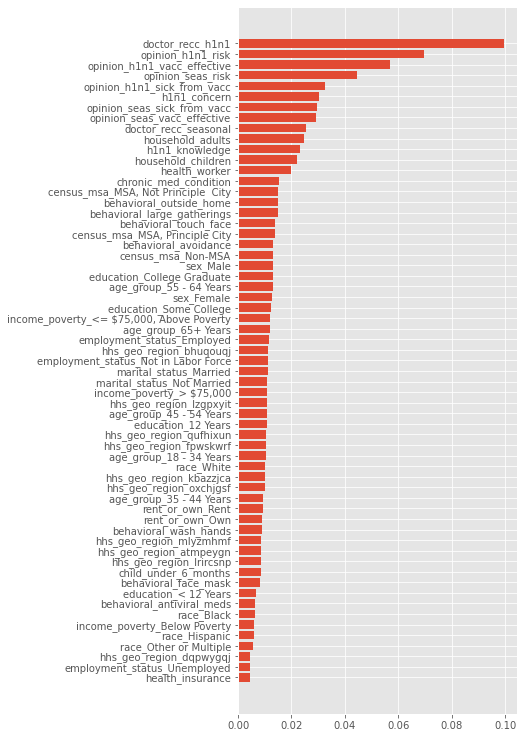

In [32]:
plot_feature_importances(rfc)